# Sprint 08. Tasca 01. Feature Scaling & Feature Engineering
## By José Manuel Castaño

## - Exercici 1

Agafa un conjunt de dades de tema esportiu que t'agradi i normalitza els atributs categòrics en dummy. Estandaritza els atributs numèrics amb StandardScaler.

Agafo el dataset **credit cards customers** amb informació d'usuaris de credit cards, utilitzat a el sprint 05, 06 i 07

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA

In [2]:
creditcard = pd.read_csv('BankChurners.csv')

Eliminem algunes columnes per recomanació del creador de l'arxiu.   
Cambiem alguns noms de les columnes per fer-los més inteligibles i operatius

In [3]:
creditcard.drop(creditcard.iloc[:,[16,19,21,22]], axis='columns', inplace=True)

In [4]:
creditcard.rename(columns={'Total_Relationship_Count':'Total_Products', 'Months_Inactive_12_mon':'Months_Inactive','Contacts_Count_12_mon':'Contacts_Count',
                           'Total_Revolving_Bal':'Revolving', 'Avg_Open_To_Buy':'Open_To_Buy','Total_Trans_Ct':'Transaction_Count','Total_Trans_Amt':'Transaction_Amount',
                           'Avg_Utilization_Ratio':'Utilization_Ratio'}, inplace=True)
creditcard.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Products,Months_Inactive,Contacts_Count,Credit_Limit,Revolving,Open_To_Buy,Transaction_Amount,Transaction_Count,Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1144,42,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1291,33,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,1887,20,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1171,20,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,816,28,0.000


La base de dades té 10.000 clients usuaris de credit cards categoritzats per edad, sexe, salari, estat civil i d'altres.   
L'explicació dels camps així com els gràfics de distribucions dels diferents atributs estan detallats a l'exercici 05 i 06

Imaginem que volem crear un model que ens faci la predicció de **Transaction_Amount** en funció de les variables de client de les que disposem

Comprobo si hi ha nulls

In [37]:
creditcard.isnull().sum()

CLIENTNUM             0
Attrition_Flag        0
Customer_Age          0
Gender                0
Dependent_count       0
Education_Level       0
Marital_Status        0
Income_Category       0
Card_Category         0
Months_on_book        0
Total_Products        0
Months_Inactive       0
Contacts_Count        0
Credit_Limit          0
Revolving             0
Open_To_Buy           0
Transaction_Amount    0
Transaction_Count     0
Utilization_Ratio     0
dtype: int64

Transformo els camps string en categòrics i ordeno els camps que tenen un ordre

In [5]:
creditcard[['Attrition_Flag','Gender','Marital_Status']].astype('category')
cat_education = pd.CategoricalDtype(categories=['Unknown','Uneducated','College','High School','Graduate','Post-Graduate','Doctorate'],ordered=True)
cat_income = pd.CategoricalDtype(categories= ['Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +','Unknown'], ordered=True)
cat_card = pd.CategoricalDtype(categories= ['Blue','Silver','Gold','Platinum'],ordered=True)
creditcard.Education_Level.astype(cat_education)
creditcard.Income_Category.astype(cat_income)
creditcard.Card_Category.astype(cat_card)

0          Blue
1          Blue
2          Blue
3          Blue
4          Blue
          ...  
10122      Blue
10123      Blue
10124      Blue
10125      Blue
10126    Silver
Name: Card_Category, Length: 10127, dtype: category
Categories (4, object): ['Blue' < 'Silver' < 'Gold' < 'Platinum']

Abans d'escalar, miro la distribució de les variables numèriques per saber a quines variables puc aplicar una estandarització o una normalització

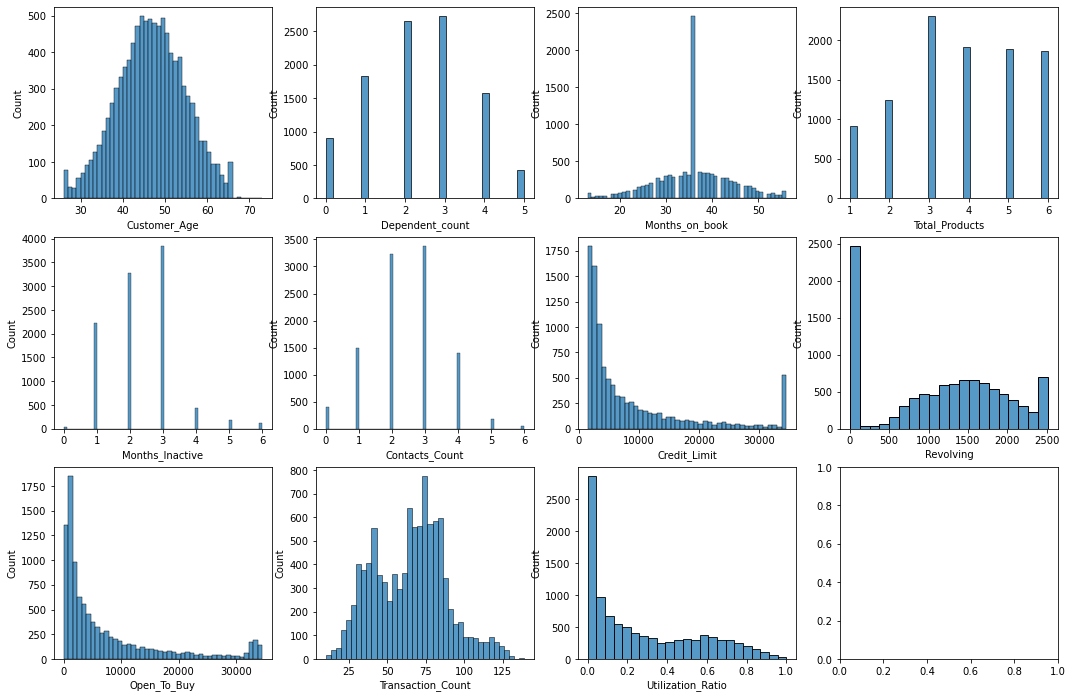

In [6]:
f, axs = plt.subplots(3,4, figsize=(18, 12), gridspec_kw=dict(width_ratios=[4, 4, 4, 4]))
sns.histplot(x=creditcard.Customer_Age, ax=axs[0,0]);
sns.histplot(x=creditcard.Dependent_count, ax=axs[0,1]);
sns.histplot(x=creditcard.Months_on_book, ax=axs[0,2]);
sns.histplot(x=creditcard.Total_Products, ax=axs[0,3]);
sns.histplot(x=creditcard.Months_Inactive, ax=axs[1,0]);
sns.histplot(x=creditcard.Contacts_Count, ax=axs[1,1]);
sns.histplot(x=creditcard.Credit_Limit, ax=axs[1,2]);
sns.histplot(x=creditcard.Revolving, ax=axs[1,3]);
sns.histplot(x=creditcard.Open_To_Buy, ax=axs[2,0]);
sns.histplot(x=creditcard.Transaction_Count, ax=axs[2,1]);
sns.histplot(x=creditcard.Utilization_Ratio, ax=axs[2,2]);

Com podem comprobar als gràfics de distribució, únicament tindria sentit fer una standarització en el cas de Customer_Age. A la resta de camps numèrics s'ha d'aplicar una normalització. 

Apliquem, per tant, la estandarització a **Customer_Age** i la normalització a la resta de camps numérics. Tots els camps ja normalitzats els tindrem al **DF x**.

In [7]:
creditcard_c = creditcard.copy()                                             #Fem una copia de creditcard
columnas_std = list(creditcard_c.columns[[2]])                               #Columnna a estandaritzar
columnas_minmax=list(creditcard_c.columns[[4,9,10,11,12,13,14,15,17,18]])    #Columnes a normalitzar
x_std= StandardScaler().fit_transform(creditcard_c[columnas_std].values)
x_minmax= MinMaxScaler().fit_transform(creditcard_c[columnas_minmax].values)

x=pd.DataFrame(np.concatenate((x_std, x_minmax), axis=1), columns=(columnas_std + columnas_minmax))
x

,Customer_Age,Dependent_count,Months_on_book,Total_Products,Months_Inactive,Contacts_Count,Credit_Limit,Revolving,Open_To_Buy,Transaction_Count,Utilization_Ratio
0,-0.165406,0.6,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,0.248062,0.061061
1,0.333570,1.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,0.178295,0.105105
2,0.583058,0.6,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,0.077519,0.000000
3,-0.789126,0.8,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,0.077519,0.760761
4,-0.789126,0.6,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,0.139535,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10122,0.458314,0.4,0.627907,0.4,0.333333,0.500000,0.077536,0.735399,0.062266,0.829457,0.462462
10123,-0.664382,0.4,0.279070,0.6,0.333333,0.500000,0.085819,0.868494,0.060499,0.457364,0.511512
10124,-0.290150,0.2,0.534884,0.8,0.500000,0.666667,0.120042,0.000000,0.156637,0.387597,0.000000
10125,-2.036565,0.4,0.534884,0.6,0.500000,0.500000,0.116172,0.000000,0.152928,0.403101,0.000000


Apliquem dummies a les variables categòriques i les afegim al **DF x** on tenim les variables numèriques. 

In [7]:
cat_vars = ['Attrition_Flag','Gender', 'Education_Level', 'Marital_Status','Income_Category', 'Card_Category']
for var in cat_vars:
    df_dummie = pd.get_dummies(creditcard_c[var], prefix=var)
    x= pd.concat([x,df_dummie], axis=1)
x.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Products,Months_Inactive,Contacts_Count,Credit_Limit,Revolving,Open_To_Buy,Transaction_Count,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,-0.165406,0.6,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,0.248062,...,0,0,1,0,0,0,1,0,0,0
1,0.333570,1.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,0.178295,...,0,0,0,0,1,0,1,0,0,0
2,0.583058,0.6,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,0.077519,...,0,0,0,1,0,0,1,0,0,0
3,-0.789126,0.8,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,0.077519,...,0,0,0,0,1,0,1,0,0,0
4,-0.789126,0.6,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,0.139535,...,0,0,1,0,0,0,1,0,0,0


## - Exercici 2

Continua amb el conjunt de dades de tema esportiu que t'agradi i aplica l'anàlisi de components principals.

Aplicarem el PCA a les variables numèriques i ja escalades. Volem que les noves variables expliquin el 0.95 de la variança

In [8]:
pca = PCA(0.95)
x_pca = pca.fit_transform(x.iloc[:,0:11])
num_var = pca.n_components_                     #Calculo en nº de components
var_pca=[f'PCA_{i}' for i in range(num_var)]    #Creo els noms dels components

x_pca=pd.DataFrame(x_pca, columns=var_pca)      
x_pca

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6
0,-0.159685,0.282845,-0.108337,-0.283955,-0.129951,0.093189,-0.205113
1,0.338092,0.104930,-0.177320,-0.414150,-0.582880,-0.008667,-0.160372
2,0.572434,0.171272,-0.540078,-0.000880,-0.194903,-0.217824,-0.059510
3,-0.785496,-0.634314,0.414107,0.145490,-0.300032,0.120445,0.410671
4,-0.836516,0.182067,-0.528669,-0.192744,-0.165096,-0.277807,-0.061706
...,...,...,...,...,...,...,...
10122,0.465741,-0.329217,0.190791,0.244040,0.060607,-0.110210,-0.151217
10123,-0.690393,-0.442182,0.252020,-0.029526,0.088124,0.064918,-0.084790
10124,-0.280826,0.206026,-0.552912,-0.222689,0.252166,0.158000,0.024450
10125,-2.012762,0.225778,-0.504994,-0.004857,0.123322,0.068846,0.107533


Veiem la variança (explicació) que pot ser atribuida a cada nova variable

In [9]:
pca.explained_variance_ratio_

array([0.6315889 , 0.11546136, 0.07644419, 0.0606115 , 0.04059038,
       0.02246912, 0.01740857])

Podem veure que les 2 primeres variables expliquen el 75% de la variança y les 3 primeres variables expliquen el 82% de la variança

## - Exercici 3

Continua amb el conjunt de dades de tema esportiu que t'agradi i normalitza les dades tenint en compte els outliers.


Fem una anàlisi dels outliers de les variables numèriques sense escalar. Per motius d'escala ho fem en 3 gràfics

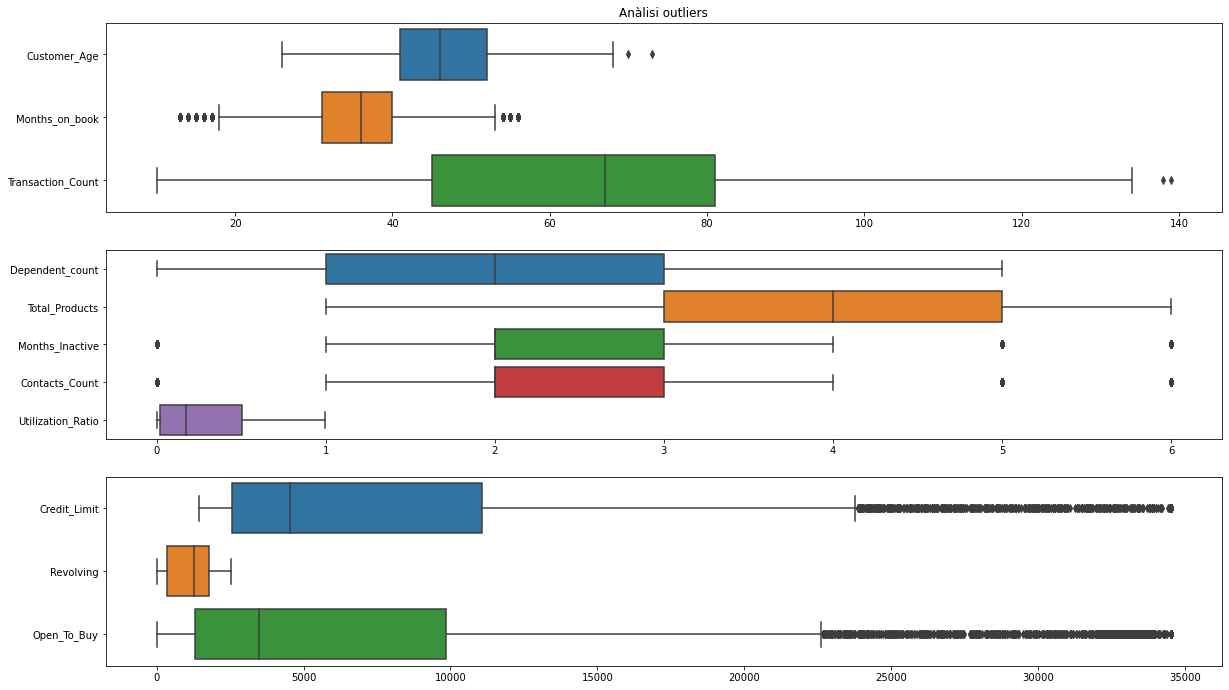

In [11]:
plt.figure(figsize=(20,16))

plt.subplot(4,1,1)
sns.boxplot(data=creditcard_c.iloc[:, [2,9,17]], orient='h');
plt.title('Anàlisi outliers')

plt.subplot(4,1,2)
sns.boxplot(data=creditcard_c.iloc[:, [4,10,11,12,18]], orient='h');

plt.subplot(4,1,3)
sns.boxplot(data=creditcard_c.iloc[:, [13,14,15]], orient='h');

In [12]:
creditcard_c.iloc[:,[2,4,9,10,11,12,13,14,15,17,18]].describe().round(2)

,Customer_Age,Dependent_count,Months_on_book,Total_Products,Months_Inactive,Contacts_Count,Credit_Limit,Revolving,Open_To_Buy,Transaction_Count,Utilization_Ratio
count,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00
mean,46.33,2.35,35.93,3.81,2.34,2.46,8631.95,1162.81,7469.14,64.86,0.27
std,8.02,1.30,7.99,1.55,1.01,1.11,9088.78,814.99,9090.69,23.47,0.28
min,26.00,0.00,13.00,1.00,0.00,0.00,1438.30,0.00,3.00,10.00,0.00
25%,41.00,1.00,31.00,3.00,2.00,2.00,2555.00,359.00,1324.50,45.00,0.02
50%,46.00,2.00,36.00,4.00,2.00,2.00,4549.00,1276.00,3474.00,67.00,0.18
75%,52.00,3.00,40.00,5.00,3.00,3.00,11067.50,1784.00,9859.00,81.00,0.50
max,73.00,5.00,56.00,6.00,6.00,6.00,34516.00,2517.00,34516.00,139.00,1.00


Hi ha variables que no tenen outliers, altres que els tenen pròxims i altres que els tenen més separats. Per tal de disminuir l'efecte dels outliers plantegem:
- No eliminarem els outliers perquè no semblen ni errors ni casos molt extrems o estranys
- Aplicarem el **RobustScaler()** que utilitza la mediana i el IQR 
- Aplicarem el **PowerTransformer()** que transforma les dades en una distribució normal

In [13]:
columnas= creditcard_c.columns[[2,4,9,10,11,12,13,14,15,17,18]]
x_robust= RobustScaler().fit_transform(creditcard_c[columnas].values)
x_robust = pd.DataFrame(x_robust, columns=columnas)
x_power= PowerTransformer().fit_transform(creditcard_c[columnas].values)
x_power = pd.DataFrame(x_power, columns=columnas)

Ara compararem les variables aplicant la normalització i estandarització del exercisi 1, aplicant el RobustScaler i aplicant el PowerTransformer 

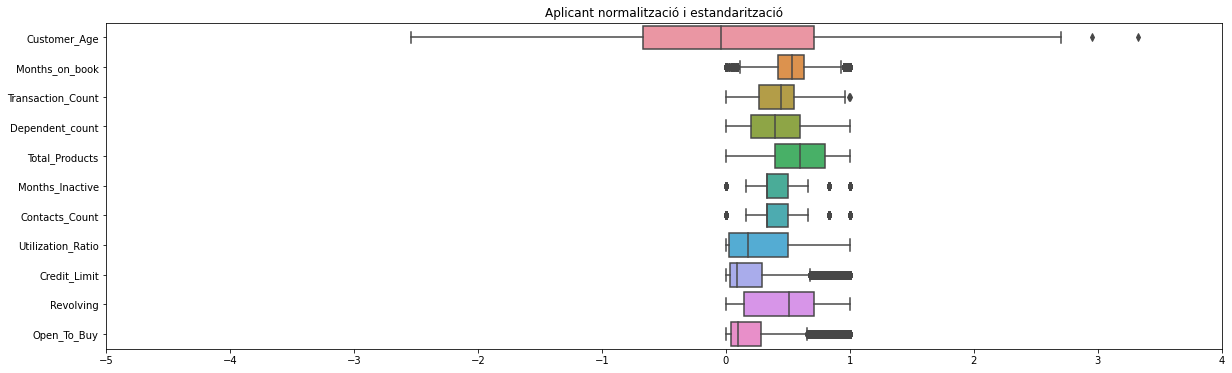

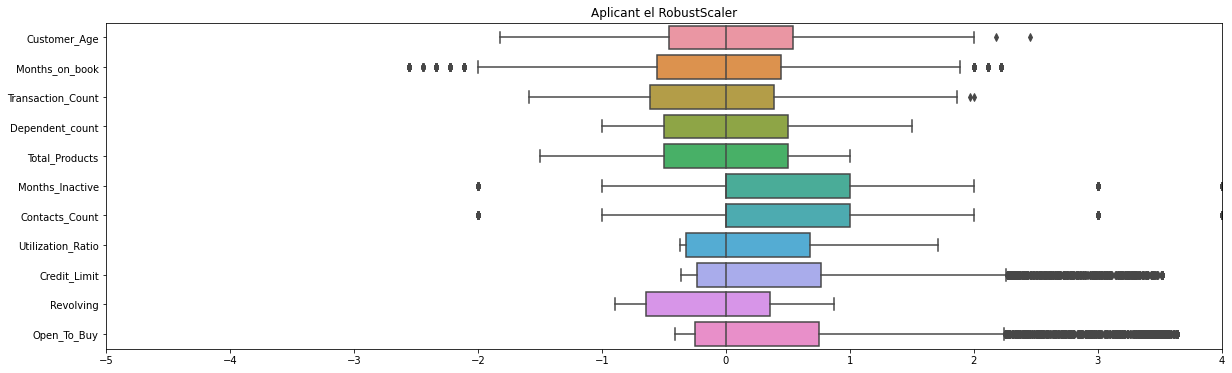

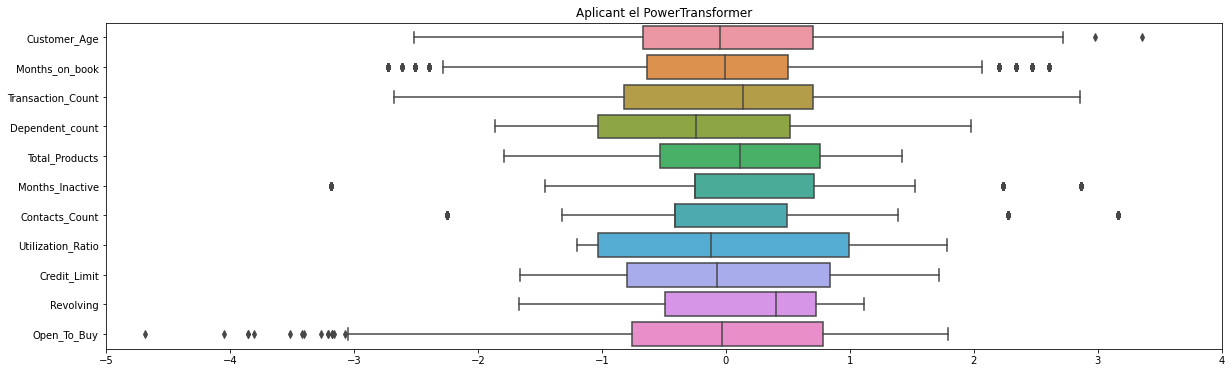

In [25]:
#Boxplots de normalització i estandarització
plt.figure(figsize=(20,6))
sns.boxplot(data=x.iloc[:, [0,2,9,1,3,4,5,10,6,7,8]], orient='h');
plt.xlim(-5, 4);
plt.title('Aplicant normalització i estandarització');

#Boxplots del RobustScaler
plt.figure(figsize=(20,6))
sns.boxplot(data=x_robust.iloc[:, [0,2,9,1,3,4,5,10,6,7,8]], orient='h');
plt.xlim(-5, 4);
plt.title('Aplicant el RobustScaler');

#Boxplots del PowerTransformer
plt.figure(figsize=(20,6))
sns.boxplot(data=x_power.iloc[:, [0,2,9,1,3,4,5,10,6,7,8]], orient='h');
plt.xlim(-5, 4);
plt.title('Aplicant el PowerTransformer');

Conclusions    
Després d'aplicar diferents tipus d'escalat a totes les variables numèriques i comparant els resultats tenim:
- Cada variable, en funció de la seva distribució, té un comportament diferent al aplicar els diferents escalats
- El PowerTransformer en general incrementa el IQR respecte al RobustScaler
- El PowerTransformer millora sensiblement el tema de outliers en les variables: Credit_Limit i Open_to_buy
